In [2]:
from data.gp import *
import torch
import neuralprocesses.torch as nps
import matplotlib.pyplot as plt

/home/vinayakrana/miniconda3/envs/tnp/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/vinayakrana/miniconda3/envs/tnp/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/vinayakrana/miniconda3/envs/tnp/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/vinayakrana/miniconda3/envs/tnp/lib/python3.9/site-packages/setuptools/_distutils/version.py:336: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vinayakrana/minicon

#### Code source for below cell https://github.com/wesselb/neuralprocesses?tab=readme-ov-file#

In [3]:
# Construct a ConvCNP.
convcnp = nps.construct_convgnp(dim_x=1, dim_y=2, likelihood="het")  # likelihood "het" = "cnp"

# Construct optimiser.
opt = torch.optim.Adam(convcnp.parameters(), 1e-3)

# Training: optimise the model for 32 batches.
for _ in range(32):
    # Sample a batch of new context and target sets. Replace this with your data. The
    # shapes are `(batch_size, dimensionality, num_data)`.
    xc = torch.randn(16, 1, 10)  # Context inputs
    yc = torch.randn(16, 2, 10)  # Context outputs
    xt = torch.randn(16, 1, 15)  # Target inputs
    yt = torch.randn(16, 2, 15)  # Target output

    # Compute the loss and update the model parameters.
    loss = -torch.mean(nps.loglik(convcnp, xc, yc, xt, yt, normalise=True))
    print(loss)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

# Testing: make some predictions.
mean, var, noiseless_samples, noisy_samples = nps.predict(
    convcnp,
    torch.randn(16, 1, 10),  # Context inputs
    torch.randn(16, 2, 10),  # Context outputs
    torch.randn(16, 1, 15),  # Target inputs
)

tensor(1.4389, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4042, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4293, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.3801, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.5186, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4670, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.5153, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4667, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.3758, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4526, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4415, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4442, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4119, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4029, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4294, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.4107, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(1.5020, dtype=torch.float64, grad

#### A sample training cycle for 1d regression problem using neural processes library 

In [4]:
# Construct a ConvCNP.
convcnp = nps.construct_convgnp(dim_x=1, dim_y=1, likelihood="het")

# Construct optimizer.
opt = torch.optim.Adam(convcnp.parameters(), 1e-2)

# Set up the GP sampler.
kernel = RBFKernel()
gp_sampler = GPSampler(kernel, t_noise=0.1)

for _ in range(100):

    batch = gp_sampler.sample(batch_size=64, x_range=(-2, 2), device="cpu")
    
    # Extract context and target points
    xc, yc = batch.xc, batch.yc  
    xt, yt = batch.xt, batch.yt  

    # change dimensions to match requirement of nps.loglik method
    xc = xc.permute(0,2,1)
    xt = xt.permute(0,2,1)
    yc = yc.permute(0,2,1)
    yt = yt.permute(0,2,1)

    loss = -torch.mean(nps.loglik(convcnp, xc, yc, xt, yt, normalise=True))
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

In [12]:
test_batch = gp_sampler.sample(batch_size=16, max_num_points=40, x_range=(-2, 2), device="cpu")
xc, yc = test_batch.xc, test_batch.yc
xt, yt = test_batch.xt, test_batch.yt

xc = xc.permute(0,2,1)
xt = xt.permute(0,2,1)
yc = yc.permute(0,2,1)
yt = yt.permute(0,2,1)

mean, var, _, _ = nps.predict(convcnp, xc, yc, xt)

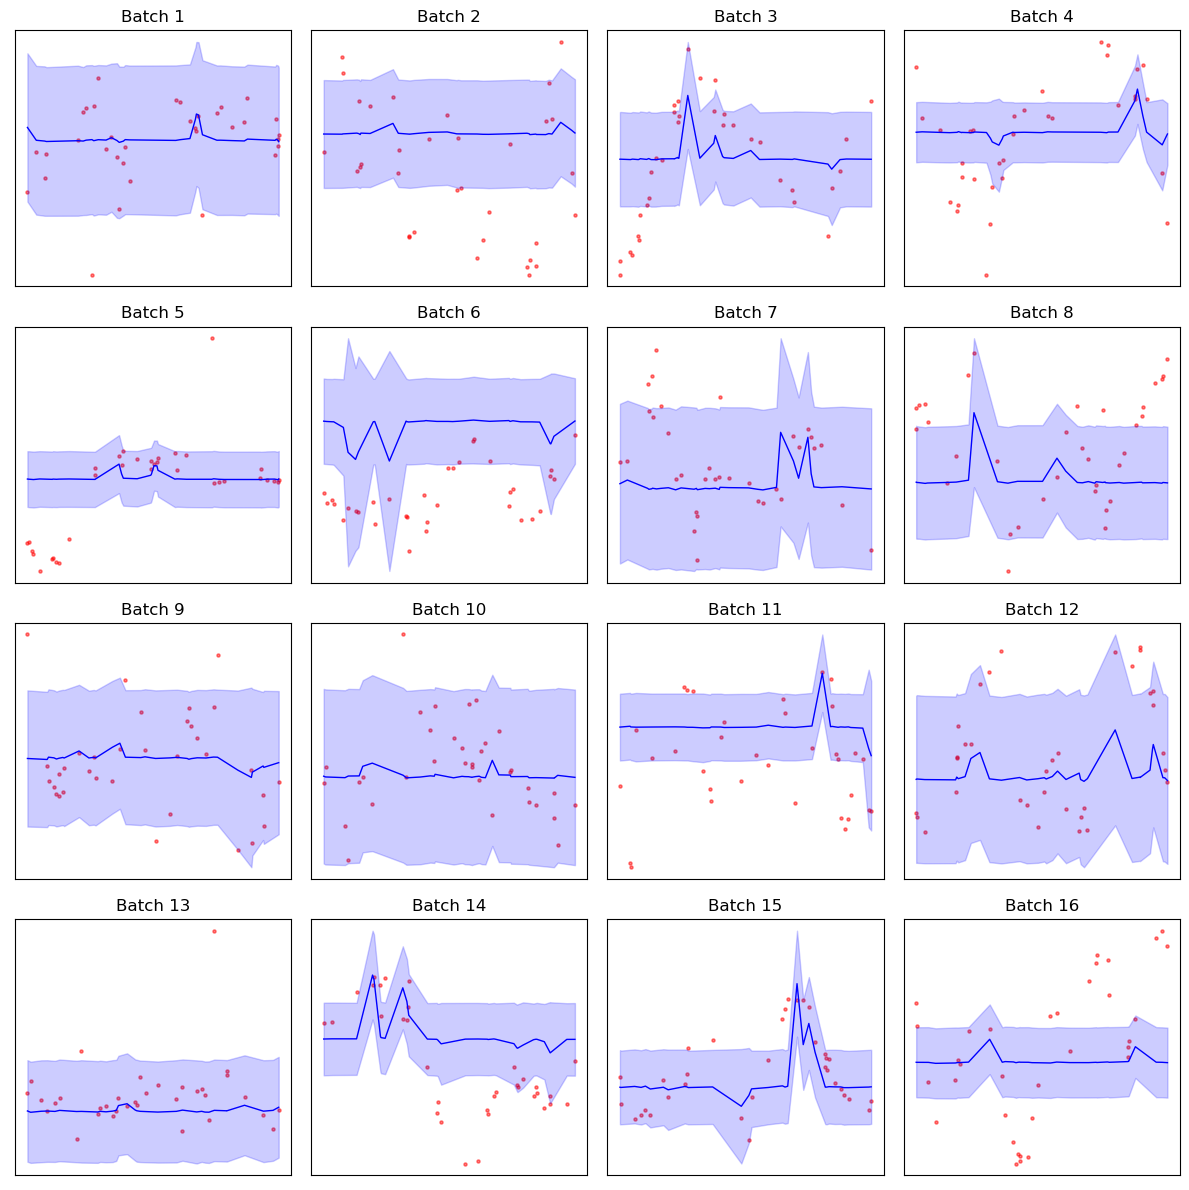

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    xt_sample = xt[i].squeeze()  
    yt_sample = yt[i].squeeze()
    mean_sample = mean[i].squeeze().detach()
    var_sample = var[i].squeeze().detach()

    # Flatten the grid for sorting
    xt_flat = xt_sample.flatten()
    yt_flat = yt_sample.flatten()
    mean_flat = mean_sample.flatten()
    var_flat = var_sample.flatten()

    # Sort by x-values
    sorted_indices = torch.argsort(xt_flat)
    xt_sorted = xt_flat[sorted_indices]
    yt_sorted = yt_flat[sorted_indices]
    mean_sorted = mean_flat[sorted_indices]
    var_sorted = var_flat[sorted_indices]

    # Plot in the respective subplot
    ax = axes[i]
    ax.scatter(xt_sorted.numpy(), yt_sorted.numpy(), color='red', alpha=0.5, s=5)
    ax.plot(xt_sorted.numpy(), mean_sorted.numpy(), 'b-', linewidth=1)
    ax.fill_between(
        xt_sorted.numpy(),
        (mean_sorted - var_sorted).numpy(),
        (mean_sorted + var_sorted).numpy(),
        color='blue', alpha=0.2
    )
    ax.set_title(f"Batch {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


#### Visualisation of the sampled functions (code src gpt + TNP-pytorch doc)

In [ ]:
kernel = RBFKernel()
gp_sampler = GPSampler(kernel, t_noise=0.1, seed=42)  

# Generate sample data
batch = gp_sampler.sample(batch_size=1, max_num_points=50, x_range=(-2, 2), device="cpu")

# Extract data
x, y = batch.x.squeeze().cpu().numpy(), batch.y.squeeze().cpu().numpy()
xc, yc = batch.xc.squeeze().cpu().numpy(), batch.yc.squeeze().cpu().numpy()
xt, yt = batch.xt.squeeze().cpu().numpy(), batch.yt.squeeze().cpu().numpy()

# Print the generated data
print("All X points:", x)
print("All Y points:", y)
print("Context X:", xc)
print("Context Y:", yc)
print("Target X:", xt)
print("Target Y:", yt)


All X points: [-0.46854496  1.8372226  -0.43820715  0.40358138 -0.97371006  1.1745653
  1.7630858  -1.4672563   1.7383924   0.3743186   1.4776177   0.27086115
  0.9643762  -0.282382    1.5417717   0.29561782 -0.9336798   0.5097966
 -0.92147326 -0.23454571 -0.81231666  1.3267419  -1.5787404  -0.9220207
 -0.5647495 ]
All Y points: [-0.07134458 -1.1026021   0.06858489 -0.7741835  -0.50092655 -0.16361777
 -0.88657445  0.02953045 -0.86916524 -0.8460243  -0.4559284  -0.9941834
 -0.40188268  0.41126248  0.2512365  -0.9705265  -0.22141053 -0.6476171
 -0.39213338  0.52393633  0.1519111  -0.25796658  0.31928465 -0.24675736
  0.24698451]
Context X: [-0.46854496  1.8372226  -0.43820715  0.40358138 -0.97371006  1.1745653
  1.7630858  -1.4672563   1.7383924 ]
Context Y: [-0.07134458 -1.1026021   0.06858489 -0.7741835  -0.50092655 -0.16361777
 -0.88657445  0.02953045 -0.86916524]
Target X: [ 0.3743186   1.4776177   0.27086115  0.9643762  -0.282382    1.5417717
  0.29561782 -0.9336798   0.5097966  -0.

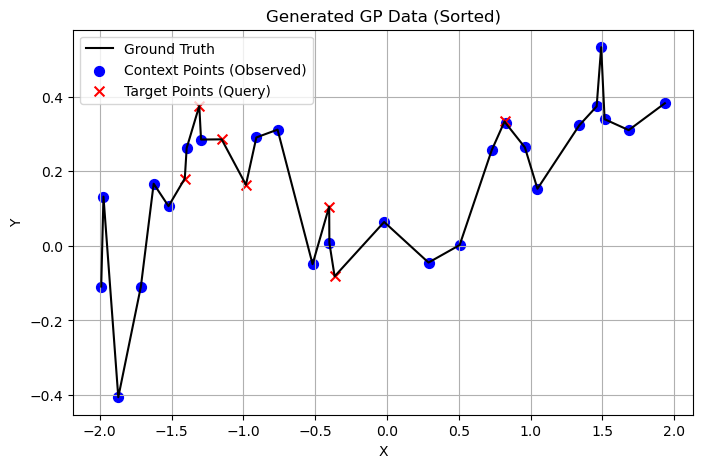

In [ ]:
# Define the kernel and sampler
kernel = RBFKernel()
gp_sampler = GPSampler(kernel, t_noise=0.1, )  

# Generate sample data
batch = gp_sampler.sample(batch_size=1, max_num_points=50, x_range=(-2, 2), device="cpu")

# Extract data
x, y = batch.x.squeeze().cpu().numpy(), batch.y.squeeze().cpu().numpy()
xc, yc = batch.xc.squeeze().cpu().numpy(), batch.yc.squeeze().cpu().numpy()
xt, yt = batch.xt.squeeze().cpu().numpy(), batch.yt.squeeze().cpu().numpy()

# Sort x and y based on x values for a smooth ground truth curve
sorted_indices = np.argsort(x)
x_sorted, y_sorted = x[sorted_indices], y[sorted_indices]

# Plot ground truth function
plt.figure(figsize=(8, 5))
plt.plot(x_sorted, y_sorted, color="black", linewidth=1.5, label="Ground Truth")

# Plot context points (observed)
plt.scatter(xc, yc, color="blue", label="Context Points (Observed)", s=50)

# Plot target points (query)
plt.scatter(xt, yt, color="red", label="Target Points (Query)", s=50, marker="x")

# Labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.title("Generated GP Data (Sorted)")

# Show the plot
plt.show()
